
# ₿ Fraud Detection on Cryptocurrency
Alur: **tema crypto → algoritma → dataset → variabel → EDA → split → training Naive Bayes → hasil**.



## 1) Kenapa ambil tema tersebut?
Transaksi digital makin umum dan rawan **fraud**. Studi kasus *crypto* dipilih untuk mensimulasikan penerapan ML pada keamanan transaksi.



## 2) Kenapa pilih Naive Bayes?
- **Sederhana** & **cepat** → cocok baseline
- Klasifikasi biner (normal vs fraud)
- Pembanding sebelum model kompleks



## 3) Dataset dari mana?
- **Synthetic dataset** (dibuat sendiri) karena data asli umumnya privat.
- Ukuran ± **5.000 baris** agar cukup untuk latihan tetapi tetap ringan.


### Import & Setup

In [1]:

# Jika environment bersih, install paket (opsional):
# !pip install numpy pandas scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             RocCurveDisplay, roc_auc_score)

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR = Path("outputs_basic"); OUT_DIR.mkdir(exist_ok=True, parents=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Generate / Load Dataset

In [2]:

csv_path = DATA_DIR / "transactions.csv"

def generate_synthetic(n_rows=5000, fraud_ratio=0.08, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)
    amount = np.round(np.exp(rng.normal(3, 1.0, n_rows)) * 10, 2)
    tx_freq = rng.poisson(lam=3, size=n_rows)
    account_age = rng.integers(low=1, high=365*3, size=n_rows)
    is_weekend = rng.integers(low=0, high=2, size=n_rows)

    base = np.full(n_rows, fraud_ratio, dtype=float)
    base += (amount > np.percentile(amount, 85)) * 0.06
    base += (account_age < 30) * 0.05
    base += (tx_freq > 6) * 0.04
    base += (is_weekend == 1) * 0.02
    base = np.clip(base, 0.01, 0.85)

    is_fraud = rng.binomial(1, base)

    return pd.DataFrame({
        "amount": amount,
        "transaction_freq_24h": tx_freq,
        "account_age_days": account_age,
        "is_weekend": is_weekend,
        "is_fraud": is_fraud
    })

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print("Loaded:", csv_path)
else:
    df = generate_synthetic()
    df.to_csv(csv_path, index=False)
    print("Generated synthetic & saved to:", csv_path)

df.head()


Loaded: data/transactions.csv


,amount,transaction_freq_24h,account_age_days,is_weekend,is_fraud
0,272.41,3,540,1,0
1,70.99,0,646,0,0
2,425.40,4,823,1,0
3,514.48,1,575,1,0
4,28.55,3,642,1,0



## 4) Variabel pada dataset
- `amount` — jumlah transaksi
- `transaction_freq_24h` — frekuensi transaksi 24 jam
- `account_age_days` — umur akun (hari)
- `is_weekend` — 0/1 apakah weekend
- `is_fraud` — label target (0 normal, 1 fraud)


## 5) EDA (Exploratory Data Analysis)

Shape: (5000, 5)

Class balance (ratio):
is_fraud
0    0.9026
1    0.0974
Name: ratio, dtype: float64


,amount,transaction_freq_24h,account_age_days,is_weekend,is_fraud
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,324.952904,3.010800,548.81260,0.496400,0.097400
std,420.948835,1.749084,312.92697,0.500037,0.296531
min,5.230000,0.000000,1.00000,0.000000,0.000000
25%,100.547500,2.000000,281.75000,0.000000,0.000000
50%,200.025000,3.000000,545.50000,0.000000,0.000000
75%,377.602500,4.000000,817.00000,1.000000,0.000000
max,6352.680000,11.000000,1094.00000,1.000000,1.000000


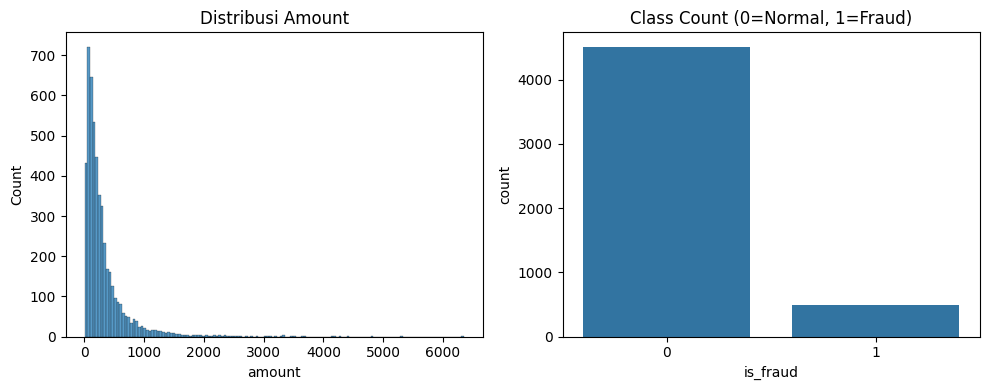

In [3]:

print("Shape:", df.shape)
print("\nClass balance (ratio):")
print(df['is_fraud'].value_counts(normalize=True).rename('ratio'))

display(df.describe())

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(df['amount'], ax=axes[0])
axes[0].set_title('Distribusi Amount')
sns.countplot(x='is_fraud', data=df, ax=axes[1])
axes[1].set_title('Class Count (0=Normal, 1=Fraud)')
plt.tight_layout(); plt.show()


## 6) Split training/testing

In [4]:

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " | Test:", X_test.shape)


Train: (4000, 4)  | Test: (1000, 4)


## 7) Training — Gaussian Naive Bayes

In [6]:

gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_prob = gnb.predict_proba(X_test)[:,1]
print("Model trained.")


Model trained.


## 8) Hasil & Evaluasi

Accuracy : 0.8870
Precision: 0.1364
Recall   : 0.0309
F1-score : 0.0504
ROC-AUC  : 0.5359

              precision    recall  f1-score   support

           0     0.9039    0.9790    0.9399       903
           1     0.1364    0.0309    0.0504        97

    accuracy                         0.8870      1000
   macro avg     0.5201    0.5049    0.4952      1000
weighted avg     0.8294    0.8870    0.8536      1000



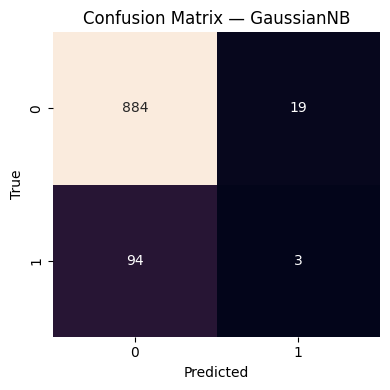

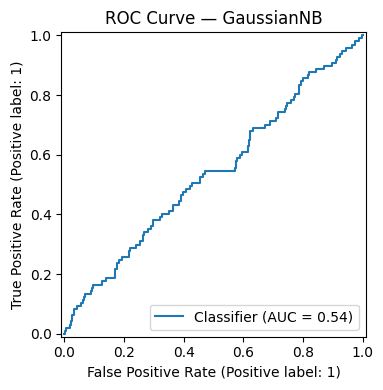

In [7]:

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=ax)
ax.set_title('Confusion Matrix — GaussianNB')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.tight_layout(); plt.show()

# ROC Curve
fig, ax = plt.subplots(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax)
ax.set_title('ROC Curve — GaussianNB')
plt.tight_layout(); plt.show()



## 9) Catatan & Next Step
- Akurasi bisa tinggi karena kelas **tidak seimbang** → fokus tingkatkan **recall** fraud.
- Coba balancing (SMOTE/undersampling), threshold tuning, atau model lain (LogReg, RF).
